# [CoE202] note 11b. DQN : cartpole
- Class Date : 21.06.10.
- Office Hour : -----------
- If you have any questions, ask via KLMS Q&A board or come to TA office hour to get our help.

1. In this example, we will implement a simple version of DQN for solving cartpole game (inverted pendulum problem). The inverted pendulum is unstable (i.e., will fall over), so the agent needs to move left or right to keep the balance.

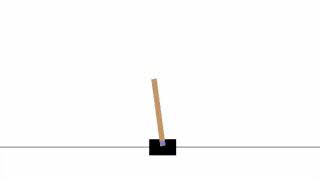

2. As usual, let's start with importing libraries!

In [ ]:
import random 
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch.distributions import Categorical
import torch.nn as nn
import torch.nn.functional as F

import gym                                    # this is for RL environment (https://gym.openai.com/)
from collections import deque               # this simplifies the implementation of the replay buffer

3. Let's specify the environment. We are going to use CartPole from OPENAI (https://gym.openai.com/)

In [ ]:
# gym environment
ENV_NAME = 'CartPole-v1'
env = gym.make(ENV_NAME)

4. Let's define our Q-network as a simple MLP. The input is a 4-dimensional vector that represents the current state: [position of cart, velocity of cart, angle of pole, rotation rate of pole]. The output is a 2-dimensional vector [Q-value for the current state and action left, Q-value for the current state and action right]

In [ ]:
class QNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(4, 48)     # four-dimensional observation ([position of cart, velocity of cart, angle of pole, rotation rate of pole])
        self.fc1 = nn.Linear(48, 64)   # hidden layer
        self.fc2 = nn.Linear(64, 2)    # two possible actions (left-right)


    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

5. Define a function for updating our Q-network.

In [ ]:
def update_Q():

    loss = 0
    for state, action, state_next, reward, done in random.sample(history, min(32, len(history))):
        with torch.no_grad():
            if done:
                target = reward
            else:
                target = reward + discount * torch.max(Q_target(state_next))

        loss = loss + (target - Q(state)[action])**2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

6. Here are our hyper-parameters.




In [ ]:
buffer_size = 1000000   # size of replay buffer
discount = 0.99         # discount factor gamma
max_time_steps = 200    # maximum episode length
target_interval = 1000  # we will update target network every THIS updates

reward_recent_history = deque(maxlen=30)  # for computing average reward over 30 episodes

7. Here's our replay buffer. deque function makes it very easy to implement :)

In [ ]:
history = deque(maxlen=buffer_size) # replay buffer

8. Let's initialize our network and the optimizer.

In [ ]:
# network and optimizer
Q = QNetwork()
optimizer = torch.optim.Adam(Q.parameters(), lr=0.0005)

# target network
Q_target = QNetwork()

9. Let's test the performance of the untrained network!

In [ ]:
# TEST (with untrained Q-network)
observation = env.reset()
rewards = 0

while True:
  
    state = torch.tensor(observation, dtype=torch.float32)
    action = torch.argmax(Q(state)).item()       
    observation, reward, done, info = env.step(action) 
    rewards = rewards + reward        
    if done: 
      break;
            
env.close()

print("Total reward is " + str(rewards) + ".")

Total reward is 8.0.


10. Define a function to keep track of the performance.

In [ ]:
def plt_history():
    clear_output(True)
    plt.figure(figsize=[16, 9])
    plt.subplot(1, 2, 1)
    plt.title("Reward history")
    plt.plot(reward_history)
    plt.grid()
    plt.show()

11. Let's start training!

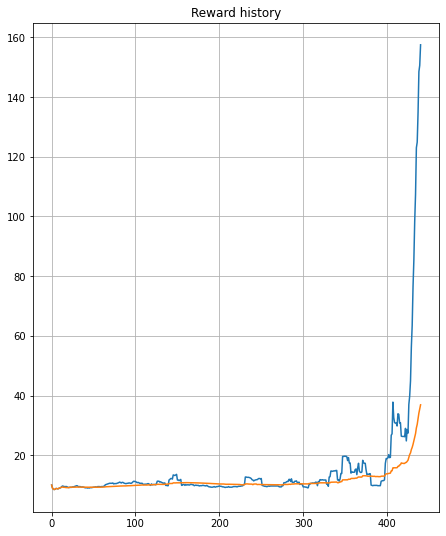

Early stopping as the exit condition is met.


In [ ]:
target_counter = 0      # counter initialization
reward_history = []
reward_history2 = []

# training
for episode in range(1000):
    # sum of accumulated rewards
    rewards = 0

    # get initial observation
    observation = env.reset()
    state = torch.tensor(observation, dtype=torch.float32)

    # loop until an episode ends
    for t in range(1, max_time_steps + 1):
        # display current environment
        #env.render()

        # epsilon greedy policy for current observation
        with torch.no_grad():
            if random.random() < 0.01:
                action = env.action_space.sample()
            else:
                action = torch.argmax(Q(state)).item()

        # proceed one step (in the environment) 
        observation_next, reward, done, info = env.step(action)
        state_next = torch.tensor(observation_next, dtype=torch.float32)

        # collect reward
        rewards = rewards + reward

        # collect a transition, put it in the replay buffer
        history.append([state, action, state_next, reward, done]) # SASR is added to the buffer
        
        # perform update 
        update_Q()

        # update target network
        target_counter = target_counter + 1
        if target_counter % target_interval == 0:
            Q_target.load_state_dict(Q.state_dict())

        if done:
            break

        # pass observation to the next step
        observation = observation_next
        state = state_next

    # compute average reward
    reward_recent_history.append(rewards)
    recent_average_reward = np.mean(reward_recent_history)
    reward_history.append(recent_average_reward)


    if episode%10 == 0:
        plt_history()

    if recent_average_reward > 0.9*max_time_steps:
        print("Early stopping as the exit condition is met.")
        break        

env.close()

12. Let's see the performance after training.

In [ ]:
# TEST (with trained Q-network)
observation = env.reset()
rewards = 0

while True:
  
    state = torch.tensor(observation, dtype=torch.float32)
    action = torch.argmax(Q(state)).item()       
    observation, reward, done, info = env.step(action) 
    rewards = rewards + reward    
        
    if done: 
      break;
            
env.close()

print("Total reward is " + str(rewards) + ".")

Total reward is 194.0.
